In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew
import matplotlib.pyplot as plt
import time
import warnings

from datetime import datetime
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNetCV, ElasticNet
from sklearn.feature_selection import SelectKBest, RFE,RFECV, mutual_info_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant


In [2]:
# Suppress Warning message

def fxn():
    warnings.warn("deprecated", DeprecationWarning)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    

def log_msg(message):
    print(str(datetime.now()) + ": " + message)

In [3]:
# Load data
train_df=pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
test_df=pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")


In [4]:
train_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [5]:
test_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal


In [6]:
print("Training data: ", train_df.shape)
print("Testing data: ", test_df.shape)

Training data:  (1460, 81)
Testing data:  (1459, 80)


## The distribution of the target variable (House sale price)

mu = 180921.20 and sigma = 79415.29


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  


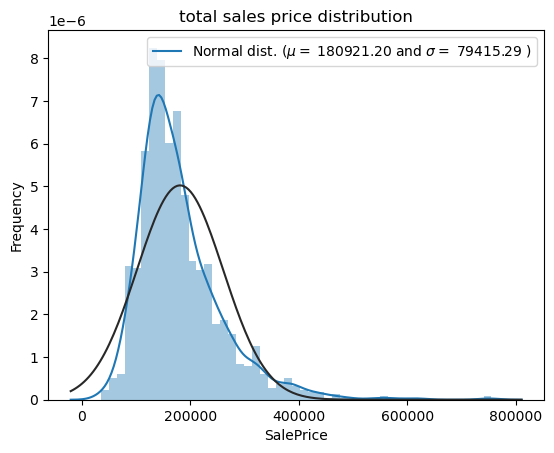

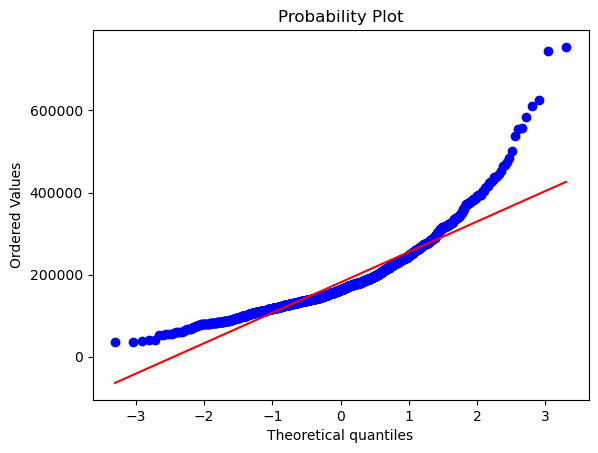

In [7]:
# Test - Distribution of Dep Var
sns.distplot(train_df['SalePrice'] , fit=norm)

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train_df['SalePrice'])
print( 'mu = {:.2f} and sigma = {:.2f}'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('total sales price distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train_df['SalePrice'], plot=plt)
plt.show()


Text(0, 0.5, 'Freq')

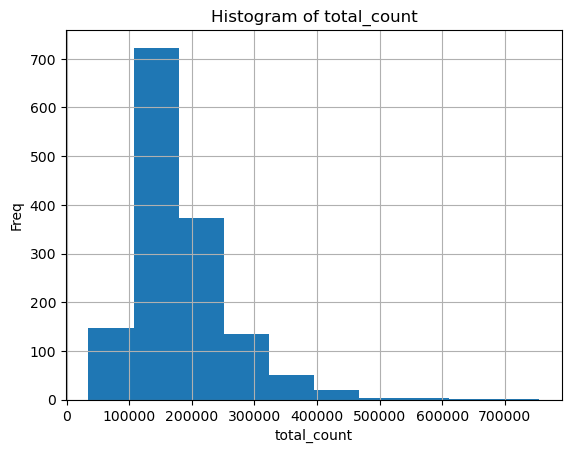

In [8]:
# An alternative View
train_df.SalePrice.hist()
plt.title('Histogram of total_count')
plt.xlabel('total_count')
plt.ylabel('Freq')

## Log transformation of the Target variable

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  


mu = 12.02 and sigma = 0.40


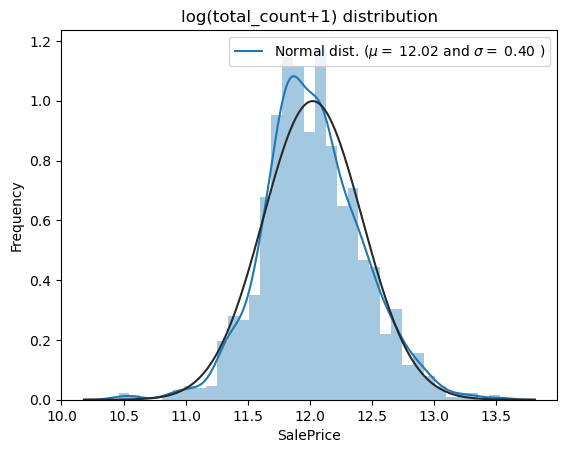

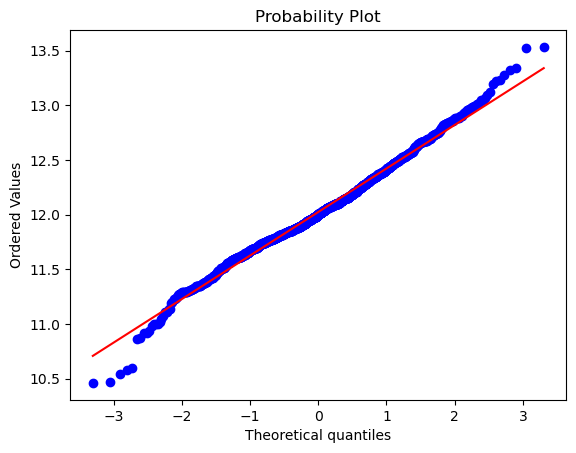

In [9]:
# Log-transformation of the Dep Variable
sns.distplot(np.log1p(train_df['SalePrice']) , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(np.log1p(train_df['SalePrice']))
print( 'mu = {:.2f} and sigma = {:.2f}'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('log(total_count+1) distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(np.log1p(train_df['SalePrice']), plot=plt)
plt.show()

In [10]:
train_df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [11]:
#missing values
missing_val_df=(train_df.isnull().sum() / len(train_df)).sort_values(ascending=False)
missing_val_df

PoolQC         0.995205
MiscFeature    0.963014
Alley          0.937671
Fence          0.807534
FireplaceQu    0.472603
                 ...   
ExterQual      0.000000
Exterior2nd    0.000000
Exterior1st    0.000000
RoofMatl       0.000000
SalePrice      0.000000
Length: 81, dtype: float64